In [26]:
import sys
import os
sys.path.append("src/")
sys.path.append("src/diffusers/")

# make sure you're logged in with `huggingface-cli login`
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, LMSDiscreteScheduler, DDIMScheduler, PNDMScheduler


os.makedirs("stable_outs", exist_ok=True)
schedulers = [LMSDiscreteScheduler, DDIMScheduler, PNDMScheduler]
lms = schedulers[0](
    beta_start=0.00085, 
    beta_end=0.012, 
    beta_schedule="scaled_linear"
)

pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", 
    scheduler=lms,
    use_auth_token=True,
    revision="fp16",
    torch_dtype=torch.float16,
).to("cuda")

def pathify_prompt(prompt):
    return prompt.replace(" ", "_").replace(",", "")

def save_image(image, prompt):
    path = f"stable_outs/{pathify_prompt(prompt)}.jpg"
    image.save(path, quality=95, subsample=False)

Num timesteps:  50
t_start: 0
Num timesteps:  50


0it [00:00, ?it/s]

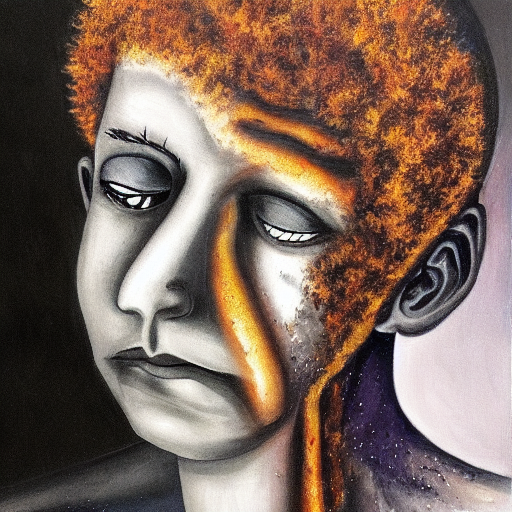

In [27]:
import numpy as np
import imageio

prompt = "My soul transcends the ashes of my body to merge with the blissful, dimensionless void. Masterpiece by Anton Wiehe"
with autocast("cuda"):
    out = pipe(prompt, output_type="latent", use_safety=False,
                        num_inference_steps=50, eta=0.75, guidance_scale=7.5, seed=0,
                        width=512, height=512, start_img=None,
                        )
    masterpiece_latent = out["sample"][0] 
    masterpiece_latent_transition = out["latents"]
    
    with torch.inference_mode():
        masterpiece_image = pipe.decode_image(masterpiece_latent.unsqueeze(0), output_type="pil")[0]
masterpiece_image

Num timesteps:  50
t_start: 0
Num timesteps:  50


0it [00:00, ?it/s]

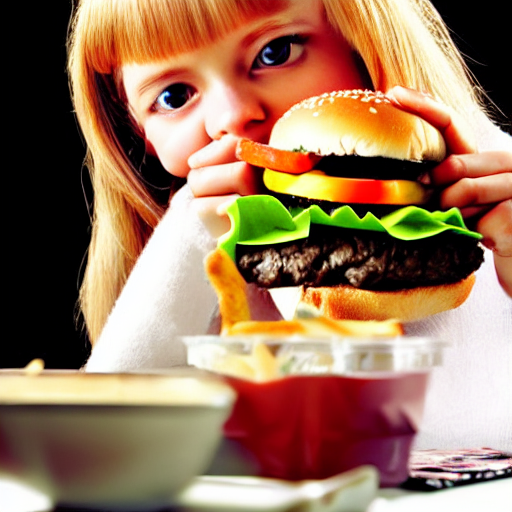

In [28]:
with autocast("cuda"):
    image = pipe(prompt="A cat eating a burger. Stock photo. Flickr", num_inference_steps=50, 
                    use_safety=False,
                    guidance_scale=10, seed=0, start_img=None)["sample"][0]
image

In [61]:
blur = 0

imgs = [masterpiece_image]
latents = [masterpiece_latent]
latent_transition_list = [masterpiece_latent_transition]

image_cat = masterpiece_image
for _ in range(3):
    with autocast("cuda"):
        
        out = pipe(prompt="A cat eating a burger. Stock photo. Flickr", 
                       num_inference_steps=20, output_type="latent",
                        noise_strength_before_encode=0.015, 
                       img2img_strength=0.6, 
                        noise_step=0, t_start=None, noise_strength=0.0,
                        guidance_scale=7, seed=0, start_img=image_cat)
        latent_cat = out["sample"][0]
        latent_cat_transitions = out["latents"]
        with torch.inference_mode():
            image_cat = pipe.decode_image(latent_cat.unsqueeze(0), output_type="pil")[0]
    image_cat.show()
    imgs.append(image_cat)
    latents.append(latent_cat)
    latent_transition_list.append(latent_cat_transitions)

Num timesteps:  20
init_timestep: 12 t_start:  8
t_start: 8
Num timesteps:  20


0it [00:00, ?it/s]

Num timesteps:  20
init_timestep: 12 t_start:  8
t_start: 8
Num timesteps:  20


0it [00:00, ?it/s]

Num timesteps:  20
init_timestep: 12 t_start:  8
t_start: 8
Num timesteps:  20


0it [00:00, ?it/s]

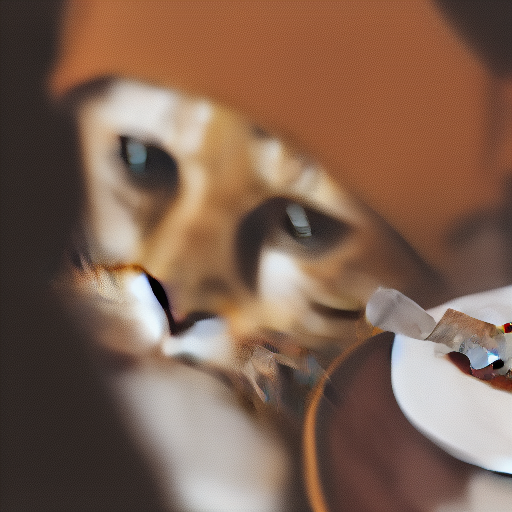

In [62]:
imgs[1]

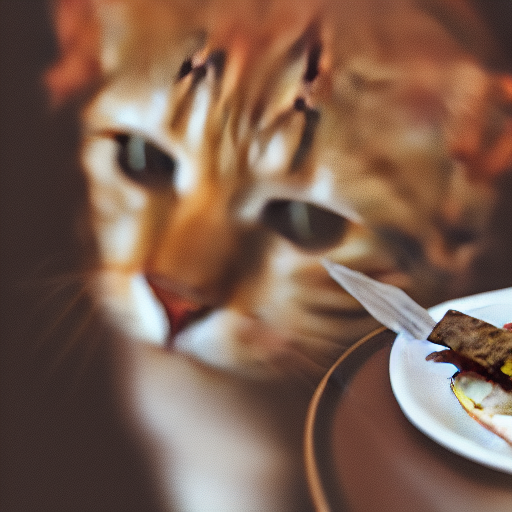

In [63]:
imgs[2]

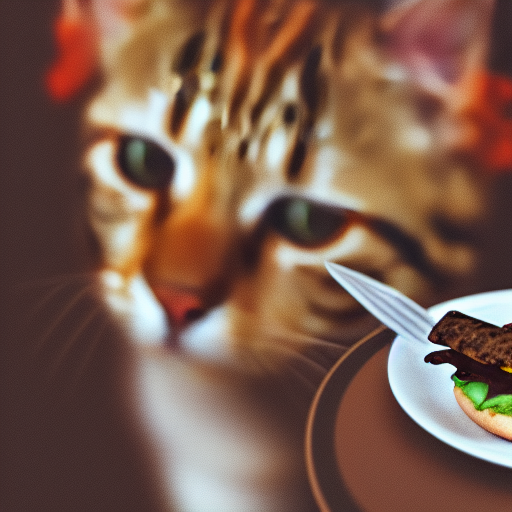

In [64]:
imgs[3]

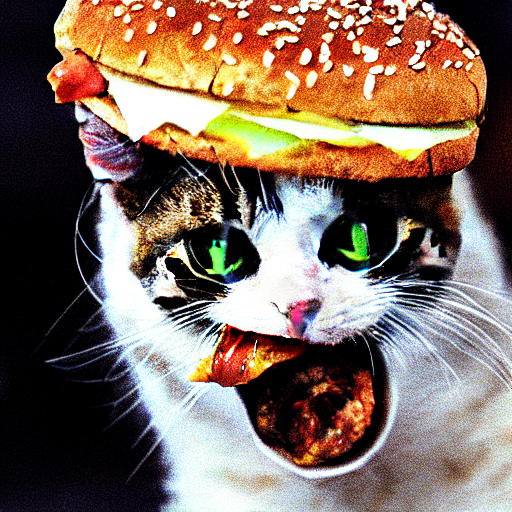

In [8]:
imgs[1]

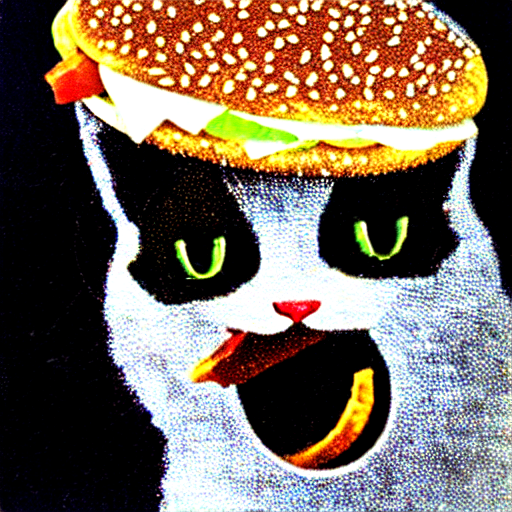

In [9]:
imgs[2]

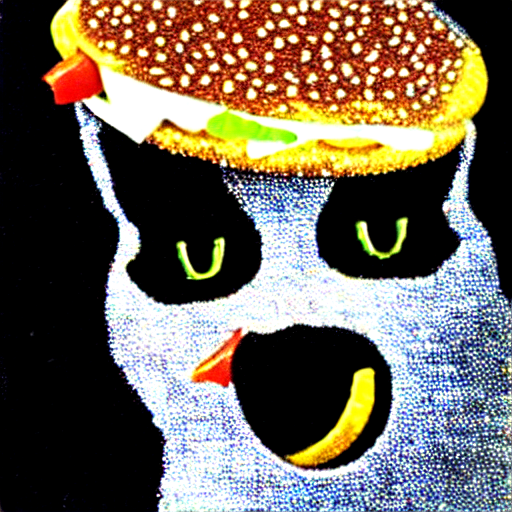

In [10]:
imgs[3]

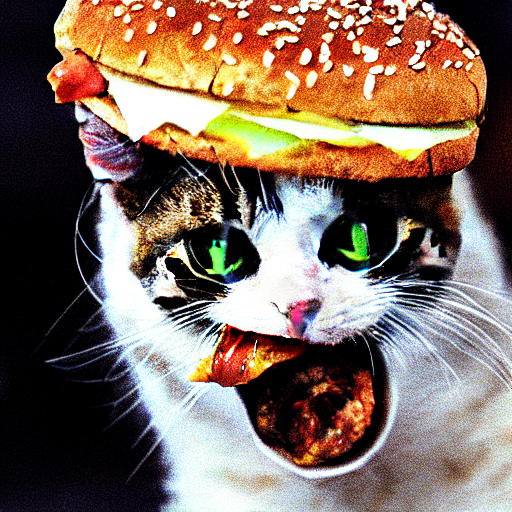

In [11]:
imgs[1]

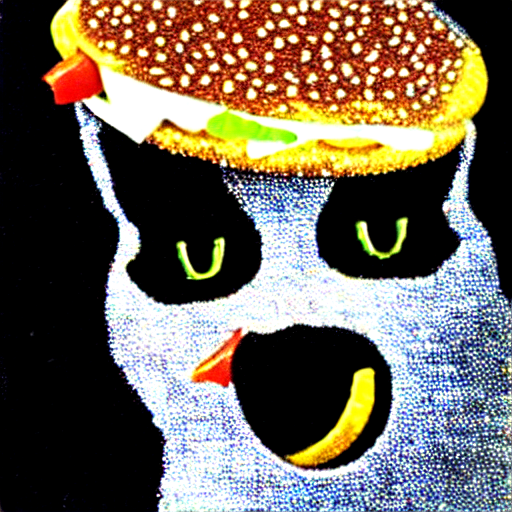

In [12]:
imgs[-1]

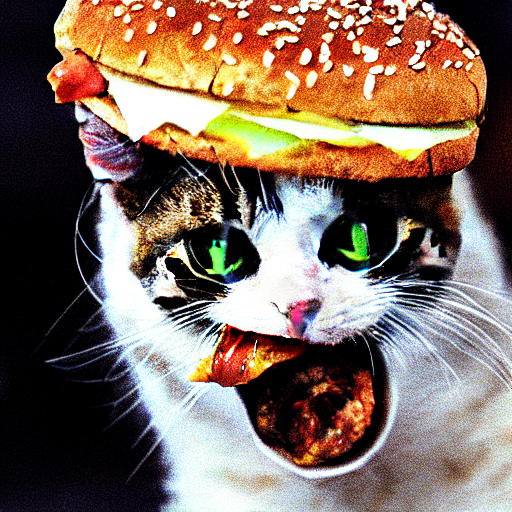

In [13]:
imgs[1]

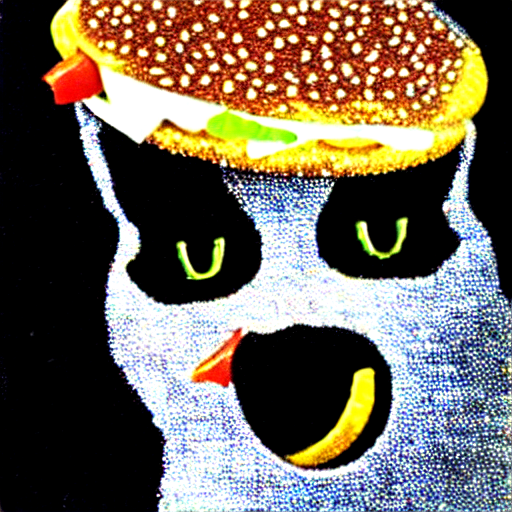

In [14]:
imgs[-1]

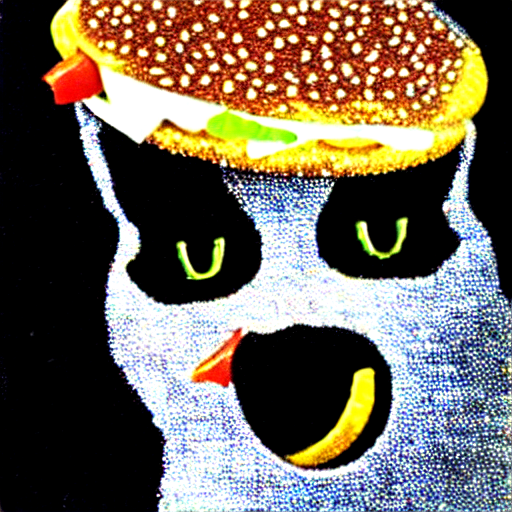

In [15]:
with autocast("cuda"):
    with torch.inference_mode():
            image_cat = pipe.decode_image(latents[-1].unsqueeze(0), output_type="pil")[0]
image_cat

In [16]:
import torchvision.transforms as T
to_pil = T.ToPILImage()

In [17]:
out = maintain_colors(imgs[-1], imgs[1], hsv=1, pil_input=True)
to_pil(out.squeeze())

NameError: name 'maintain_colors' is not defined

In [ ]:
imgs[1]

In [ ]:
imgs[0]

In [ ]:
imgs[1]

In [ ]:
imgs[-1]

In [ ]:
imgs[1]

In [ ]:
imgs[-1]

In [ ]:
imgs[4]

In [ ]:
imgs[-1]

In [ ]:
imgs[-1]

In [ ]:
imgs = [masterpiece_image]
latents = [masterpiece_latent]
latent_transition_list = [masterpiece_latent_transition]

image_cat = masterpiece_image
for _ in range(5):
    with autocast("cuda"):
        out = pipe(prompt="A cat eating a burger", num_inference_steps=50, output_type="latent",
                        noise_strength_before_encode=0.0, img2img_strength=0.7, use_safety=False,
                        guidance_scale=10, seed=0, start_img=image_cat)
        latent_cat = out["sample"][0]
        latent_cat_transitions = out["latents"]
        with torch.inference_mode():
            image_cat = pipe.decode_image(latent_cat.unsqueeze(0), output_type="pil")[0]
    image_cat.show()
    imgs.append(image_cat)
    latents.append(latent_cat)
    latent_transition_list.append(latent_cat_transitions)

In [ ]:
imgs[]

In [ ]:
def sample_from_cv2(sample: np.ndarray) -> torch.Tensor:
    sample = ((sample.astype(float) / 255.0) * 2) - 1
    sample = sample[None].transpose(0, 3, 1, 2).astype(np.float16)
    sample = torch.from_numpy(sample)
    return sample


def sample_to_cv2(sample: torch.Tensor) -> np.ndarray:
    from einops import rearrange
    sample_f32 = rearrange(sample.squeeze().cpu().numpy(), "c h w -> h w c").astype(np.float32)
    sample_f32 = ((sample_f32 * 0.5) + 0.5).clip(0, 1)
    sample_int8 = (sample_f32 * 255).astype(np.uint8)
    return sample_int8


def maintain_colors(prev_img, color_match_sample, hsv=False, pil_input=False):
    from skimage.exposure import match_histograms
    import cv2
    if pil_input:
        prev_img = torch.tensor(np.array(prev_img)).permute(2, 0, 1).unsqueeze(0) / 255
        color_match_sample = torch.tensor(np.array(color_match_sample)).permute(2, 0, 1).unsqueeze(0) / 255
    prev_img = sample_to_cv2(prev_img)
    color_match_sample = sample_to_cv2(color_match_sample)
    if hsv:
        prev_img_hsv = cv2.cvtColor(prev_img, cv2.COLOR_RGB2HSV)
        color_match_hsv = cv2.cvtColor(color_match_sample, cv2.COLOR_RGB2HSV)
        matched_hsv = match_histograms(prev_img_hsv, color_match_hsv, multichannel=True)
        img = cv2.cvtColor(matched_hsv, cv2.COLOR_HSV2RGB)
    else:
        img = match_histograms(prev_img, color_match_sample, multichannel=True)
    img = sample_from_cv2(img)
    return img

In [ ]:
import matplotlib.pyplot as plt
def plot_latents(latents, show=True):
    latents = latents.cpu()
    for channel in latents:
        vals = channel.flatten()
        plt.hist(vals.numpy(), bins=20)
    if show:
        plt.show()
    import io 
    from PIL import Image
    with io.BytesIO() as img_buf:
        plt.savefig(img_buf, format='png')
        im = Image.open(img_buf)
    return im

In [ ]:
type(plots[0])

In [ ]:
means = [l.cpu().abs().mean() for l in latents]
plt.plot(means)

In [ ]:
stds = [l.cpu().abs().std() for l in latents]
plt.plot(stds)

In [ ]:
plot_latents(torch.randn(4, 64, 64))

In [ ]:
torch.randn(4, 64, 64).mean()

In [ ]:
plot_latents(latents[0])
imgs[0]

In [ ]:
plot_latents(latents[1])
imgs[1]

In [ ]:
plot_latents(latents[2])
imgs[2]

In [ ]:
plot_latents(latents[-1])
imgs[-1]

In [ ]:
latents.shape

In [ ]:
out = plot_latents(latent_transition_list[0][0].squeeze(), show=True)

In [ ]:
# normal optimization step 15 (start of other optimizations)
out = plot_latents(latent_transition_list[0][14].squeeze(), show=True)

In [ ]:
# normal optimization mid
out = plot_latents(latent_transition_list[0][30].squeeze(), show=True)

In [ ]:
# normal optimization end
out = plot_latents(latent_transition_list[0][-1].squeeze(), show=True)

In [ ]:

out = plot_latents(latent_transition_list[1][-1].squeeze(), show=True)

In [ ]:
out = plot_latents(latent_transition_list[2][0].squeeze(), show=True)

In [ ]:
out = plot_latents(latent_transition_list[-1][0].squeeze(), show=True)

In [ ]:
# TODO: check sigmas of optimization for first run and others

In [ ]:
# TODO: possiblity to get correct noise strength: use intermediate latents from last optimization run. Need to adjust num steps and sigmas (same num inference steps but increase t_start)
# we should do that anyways for mtv to avoid the need to encode the old image to get the latent to be faster
# TODO: CAREFUL, this does not work at all when applying transformations to the old image.... we need to encode the old image to get the correct latent

In [ ]:
# show latent transtion for normal optimization
plots = []
for latents_of_trans in latent_transition_list[0]:
    img = plot_latents(latents_of_trans.squeeze(), show=True)
    plots.append(img)

In [ ]:
np.array(plots[0]).shape

In [ ]:
import imageio
import os
os.makedirs("tmp", exist_ok=True)
imageio.mimsave('./tmp/latent_transition.gif', [np.array(p) for p in plots])

In [ ]:
import matplotlib.pyplot as plt
p = plt.hist(np.array(masterpiece_image)[:,:,0].flatten(), bins=100)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
p = plt.hist(np.array(imgs[1])[:,:,0].flatten(), bins=100)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
p = plt.hist(np.array(imgs[2])[:,:,0].flatten(), bins=100)
plt.show()

In [ ]:
tensor_out = maintain_colors(imgs[1], imgs[2], pil_input=True, hsv=True)
import torchvision
to_pil = torchvision.transforms.ToPILImage()
pil_img = to_pil(tensor_out.squeeze())
pil_img

In [ ]:
import matplotlib.pyplot as plt
p = plt.hist(np.array(pil_img)[:,:,0].flatten(), bins=100)
plt.show()

In [ ]:
tensor_out = maintain_colors(imgs[1], imgs[0], pil_input=True, hsv=True)
import torchvision
to_pil = torchvision.transforms.ToPILImage()
pil_img = to_pil(tensor_out.squeeze())
pil_img

In [ ]:
with autocast("cuda"):
    image_cat = pipe(prompt="A cat eating a burger", num_inference_steps=50, 
                    noise_strength_before_encode=0.9, use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image_cat.show()
for _ in range(10):
    with autocast("cuda"):
        image_cat = pipe(prompt="A cat eating a burger", num_inference_steps=50, 
                        noise_strength_before_encode=0.9, use_safety=False,
                        guidance_scale=6, seed=0, start_img=image_cat)["sample"][0]
    image_cat.show()

In [ ]:
with autocast("cuda"):
    image_cat = pipe(prompt="A cat eating a burger", num_inference_steps=50, 
                    noise_strength_before_encode=0.7, use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image_cat.show()
for _ in range(10):
    with autocast("cuda"):
        image_cat = pipe(prompt="A cat eating a burger", num_inference_steps=50, 
                        noise_strength_before_encode=0.7, use_safety=False,
                        guidance_scale=6, seed=0, start_img=image_cat)["sample"][0]
    image_cat.show()

In [ ]:
with autocast("cuda"):
    image_cat = pipe(prompt="A cat eating a burger", num_inference_steps=50, 
                    noise_strength_before_encode=0.7, t_start=15, use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image_cat.show()
for _ in range(10):
    with autocast("cuda"):
        image_cat = pipe(prompt="A cat eating a burger", num_inference_steps=50, 
                        noise_strength_before_encode=0.7, t_start=15, use_safety=False,
                        guidance_scale=6, seed=0, start_img=image_cat)["sample"][0]
    image_cat.show()

In [ ]:
with autocast("cuda"):
    image = pipe(prompt="A photo of a cat eating a burger. Realism", num_inference_steps=50, 
                    img2img_strength=0.99, use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image

In [ ]:
with autocast("cuda"):
    image = pipe(prompt="A cat eating a burger", num_inference_steps=50, 
                    img2img_strength=0.9, use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image

In [ ]:
with autocast("cuda"):
    image_cat = pipe(prompt="A drunk duck attacks someone in a park", num_inference_steps=50, 
                    img2img_strength=0.9, use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image_cat.show()

In [ ]:
with autocast("cuda"):
    image_cat = pipe(prompt="A photo of a duck that is attacking Donald Trump", num_inference_steps=100, 
                    img2img_strength=0.9, use_safety=False,
                    guidance_scale=7.5, seed=0, start_img=masterpiece_image)["sample"][0]
image_cat.show()

In [ ]:
with autocast("cuda"):
    image_cat = pipe(prompt="A photo of a duck attacking Donald Trump in a park", num_inference_steps=100, 
                    img2img_strength=0.9, use_safety=False,
                    guidance_scale=7.5, seed=0, start_img=masterpiece_image)["sample"][0]
image_cat.show()

In [ ]:
with autocast("cuda"):
    image_cat = pipe(prompt="A photo of a duck attacking Donald Trump in a park", num_inference_steps=100, 
                    img2img_strength=0.9, use_safety=False,
                    guidance_scale=7.5, seed=0, start_img=None)["sample"][0]
image_cat.show()

In [ ]:
with autocast("cuda"):
    image_cat = pipe(prompt="A drunk duck is attacking Donald Trump. It looks very aggressive and Trump is hurt badly", num_inference_steps=100, 
                    img2img_strength=0.9, use_safety=False,
                    guidance_scale=7.5, seed=0, start_img=masterpiece_image)["sample"][0]
image_cat.show()

In [ ]:
for _ in range(10):
    with autocast("cuda"):
        image_cat = pipe(prompt="A drunk duck is attacking Donald Trump. It looks very aggressive and Trump is hurt badly, num_inference_steps=50, 
                        img2img_strength=0.9, use_safety=False,
                        guidance_scale=6, seed=0, start_img=image_cat)["sample"][0]
    image_cat.show()

In [ ]:
with autocast("cuda"):
    image_cat = pipe(prompt="A cat eating a burger", num_inference_steps=50, 
                    img2img_strength=0.9, use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image_cat.show()
for _ in range(10):
    with autocast("cuda"):
        image_cat = pipe(prompt="A cat eating a burger", num_inference_steps=50, 
                        img2img_strength=0.9, use_safety=False,
                        guidance_scale=6, seed=0, start_img=image_cat)["sample"][0]
    image_cat.show()

In [ ]:
with autocast("cuda"):
    image = pipe(prompt="A cat eating a burger", num_inference_steps=50, 
                    img2img_strength=0.8, use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image

In [ ]:
masterpiece_image

In [ ]:
with autocast("cuda"):
    image = pipe(prompt="The machine elves are laughing at us", num_inference_steps=50, 
                    img2img_strength=0.6, use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image

In [ ]:
with autocast("cuda"):
    image = pipe(prompt="The machine elves are laughing at us", num_inference_steps=50, 
                    img2img_strength=0.8, use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image

In [ ]:
with autocast("cuda"):
    image = pipe(prompt="A cat eating a burger", num_inference_steps=50, 
                    img2img_strength=0.8, use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image

In [ ]:
with autocast("cuda"):
    image = pipe(prompt="A cat eating a burger", num_inference_steps=50, 
                    img2img_strength=0.7, use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image

In [ ]:
with autocast("cuda"):
    image_cat = pipe(prompt="A cat eating a burger", num_inference_steps=50, 
                    img2img_strength=0.8, use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image.show()


In [ ]:
with autocast("cuda"):
    image_cat = pipe(prompt="A cat eating a burger", num_inference_steps=50, 
                    img2img_strength=0.7, use_safety=False,
image.show()
for _ in range(10):
    with autocast("cuda"):
        image_cat = pipe(prompt="A cat eating a burger", num_inference_steps=50, 
                        img2img_strength=0.7, use_safety=False,
                        guidance_scale=6, seed=0, start_img=image_cat)["sample"][0]

In [ ]:
with autocast("cuda"):
    image = pipe(prompt="A cat eating a burger", num_inference_steps=10, 
                    img2img_strength=0.7, use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image

In [ ]:
with autocast("cuda"):
    image = pipe(prompt="A cat eating a burger", num_inference_steps=50, 
                    img2img_strength=0.6, use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image

In [ ]:
with autocast("cuda"):
    image = pipe(prompt="A cat eating a burger", num_inference_steps=50, 
                    img2img_strength=0.5, use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image

In [ ]:
with autocast("cuda"):
    cat_image = pipe(prompt="A cat eating a burger", num_inference_steps=50, 
                    img2img_strength=0.5, use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image.show()

In [ ]:
with autocast("cuda"):
    image = pipe(prompt="A cat eating a burger", num_inference_steps=50, 
                    img2img_strength=0.3, use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image

In [ ]:
with autocast("cuda"):
    image = pipe(prompt="A cat eating a burger", num_inference_steps=50, 
                    noise_step=937,
                    t_start=3,
                    use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image

In [ ]:
with autocast("cuda"):
    image = pipe(prompt="A cat eating a burger", num_inference_steps=100, 
                    noise_strength=0.8,
                    t_start=30,
                    use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image

In [ ]:
with autocast("cuda"):
    image = pipe(prompt="A cat eating a burger", num_inference_steps=50, 
                    noise_step=200,
                    t_start=40,
                    use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image

In [ ]:
with autocast("cuda"):
    image = pipe(prompt="A cat eating a burger", num_inference_steps=50, 
                    noise_step=800,
                    t_start=0,
                    use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image

In [ ]:
with autocast("cuda"):
    image = pipe(prompt="A cat eating a burger", num_inference_steps=50, 
                    noise_step=900,
                    t_start=0,
                    use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image

In [ ]:
pipe.scheduler

In [ ]:
noise_strength = 0
noise_step = 285
img2img_strength = 0.0

num_inference_steps = 50
offset = 0
batch_size = 1

with autocast("cuda"):
    with torch.inference_mode():
        latents = pipe.encode_image(masterpiece_image)
        # add noise
        noise = torch.randn_like(latents, device=pipe.device)
        if noise_strength is not None and noise_strength is not 0:
            # old method to add noise:
            noisy_latents = latents * (1 - noise_strength) + noise * noise_strength
        elif noise_step is not None and noise_step > 0:
            # now we use the scheduler to add noise
            noisy_latents = pipe.scheduler.add_noise(latents, noise, noise_step)
        elif img2img_strength is not None and img2img_strength is not 0:
            init_timestep = int(num_inference_steps * img2img_strength) + offset
            init_timestep = min(init_timestep, num_inference_steps)
            print("init_timestep:", init_timestep)
            timesteps = int(pipe.scheduler.timesteps[-init_timestep])
            timesteps = torch.tensor([timesteps] * batch_size, dtype=torch.long, device=pipe.device)
            # add noise to latents using the timesteps
            print("timesteps:", timesteps)
            noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)
        else: 
            noisy_latents = latents
            
        decoded = pipe.decode_image(noisy_latents)[0]
decoded.show()

In [ ]:
with autocast("cuda"):
    with torch.inference_mode():
        decoded = pipe.decode_image(latents)[0]
decoded

In [ ]:
quant = torch.quantile(latents.float().abs(), 0.9)
print(quant)
clipped_latent = torch.clip(latents, -quant, quant) #/ quant
with autocast("cuda"):
    with torch.inference_mode():
        decoded = pipe.decode_image(clipped_latent)[0]
decoded

In [ ]:
with autocast("cuda"):
    image = pipe(prompt="A cat eating a burger", num_inference_steps=30, 
                    noise_step=900, use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image

In [ ]:
with autocast("cuda"):
    image = pipe(prompt="A cat eating a burger", num_inference_steps=30, 
                    noise_step=950, use_safety=False,
                    guidance_scale=6, seed=0, start_img=masterpiece_image)["sample"][0]
image

In [ ]:
with autocast("cuda"):
    image = pipe(prompt="A cat eating a burger", num_inference_steps=30, 
                    noise_step=990, use_safety=False,
                    guidance_scale=10, seed=0, start_img=masterpiece_image)["sample"][0]
image

In [ ]:
with autocast("cuda"):
    image = pipe(prompt="A cat eating a burger with its paws", num_inference_steps=30, 
                    noise_step=990, use_safety=False,
                    guidance_scale=10, seed=0, start_img=masterpiece_image)["sample"][0]
image

In [ ]:
with autocast("cuda"):
    image = pipe(prompt="A cat eating a burger", num_inference_steps=30, 
                    noise_step=999, use_safety=False, dynamic_thresholding_quant=0.0001,
                    guidance_scale=6, seed=0, start_img=None)["sample"][0]
image